<a href="https://colab.research.google.com/github/PCsujan/LSTM_algorithms/blob/main/DeepNepse_Predictor__with_Indicators_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

import numpy as np
import pandas as pd


In [10]:

full_df = pd.read_csv("/content/sample_data/NEPSE_STOCKS_DATASETS.csv")
full_df.sample(5)


,Symbol,Date,Open,High,Low,Close,Vol
29628,BFC,2018-04-19,125.0,127.0,125.0,125.0,820
549871,UIC,2017-05-09,1536.0,1565.0,1538.0,1540.0,8783
541533,TPC,2024-10-24,466.0,480.0,458.0,476.0,23129
466349,SFL,2014-09-28,165.0,162.0,159.0,159.0,382
360149,NRN,2021-09-01,867.0,887.0,833.0,850.0,38619


In [11]:

full_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572844 entries, 0 to 572843
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Symbol  572844 non-null  object 
 1   Date    572844 non-null  object 
 2   Open    572844 non-null  float64
 3   High    572844 non-null  float64
 4   Low     572844 non-null  float64
 5   Close   572844 non-null  float64
 6   Vol     572844 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 30.6+ MB


<Axes: xlabel='Symbol'>

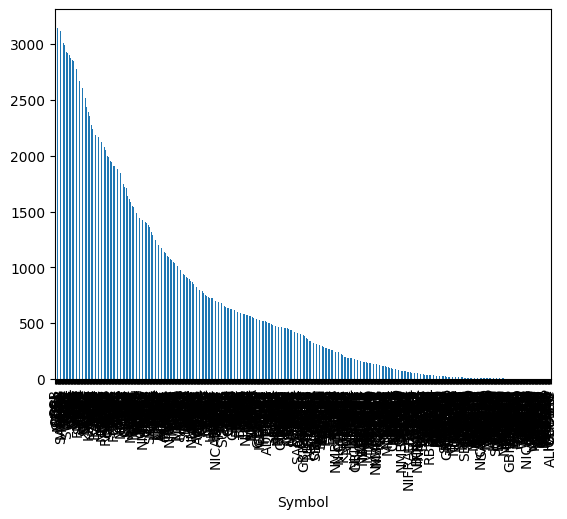

In [12]:

full_df.Symbol.value_counts().plot(kind='bar')


In [13]:

full_df.Symbol.nunique()


835

In [14]:

commercial_banks = [
    "ADBL", "EBL", "CZBIL", "GBIME", "HBL", "KBL",
    "MBL", "NABIL", "NBL", "NICA", "NIMB", "NMB",
    "PRVU", "SANIMA", "SBI"
]

# Filter only commercial banks
df = full_df[full_df["Symbol"].isin(commercial_banks)]

# Save filtered dataset for later use
df.to_csv("filtered_commercial_banks.csv", index=False)

print("✅ Full dataset stored in full_df")
print("✅ Filtered commercial banks stored in df and saved as filtered_commercial_banks.csv")

# Quick check
print("Full dataset shape:", full_df.shape)
print("Filtered dataset shape:", df.shape)
df.sample(5)


✅ Full dataset stored in full_df
✅ Filtered commercial banks stored in df and saved as filtered_commercial_banks.csv
Full dataset shape: (572844, 7)
Filtered dataset shape: (41294, 7)


,Symbol,Date,Open,High,Low,Close,Vol
185071,KBL,2013-10-17,301.0,302.0,301.0,301.0,2500
79228,CZBIL,2021-05-16,315.0,320.0,314.0,319.0,96853
287692,NBL,2019-02-10,285.0,287.0,285.0,286.0,25877
332366,NIMB,2024-02-13,169.1,169.9,168.2,168.5,84054
446966,SBI,2017-03-14,1072.0,1070.0,1056.0,1056.0,560


In [15]:
Symbols_to_keep = df.Symbol.value_counts()[:20].index.tolist()
df_filtered = df[df.Symbol.isin(Symbols_to_keep)].copy()
df_filtered.info()
df_filtered.Symbol.value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 41294 entries, 1960 to 448935
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Symbol  41294 non-null  object 
 1   Date    41294 non-null  object 
 2   Open    41294 non-null  float64
 3   High    41294 non-null  float64
 4   Low     41294 non-null  float64
 5   Close   41294 non-null  float64
 6   Vol     41294 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 2.5+ MB


,count
Symbol,
EBL,3155
ADBL,3149
CZBIL,3149
NABIL,3149
SBI,3139
SANIMA,3110
KBL,2931
NBL,2923
HBL,2878


In [16]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm # A library for progress bars


In [17]:

class LSTMModel(nn.Module):
    """A simple LSTM or GRU model for time-series prediction."""
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1, model_type='LSTM'):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.model_type = model_type

        if model_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_layer_size, batch_first=True)
        else:
            raise ValueError("model_type must be 'LSTM' or 'GRU'")

        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # Use the selected RNN layer
        rnn_out, _ = self.rnn(input_seq)
        predictions = self.linear(rnn_out[:, -1, :])
        return predictions


In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [19]:

SEQUENCE_LENGTH = 10 # Define the sequence length
TRAIN_SPLIT_PERCENT = 0.8
LEARNING_RATE = 0.001
EPOCHS = 90
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Define


In [20]:
def train_all_stock_models(df):
    Symbols = df['Symbol'].unique()
    lstm_models = {}
    gru_models = {}
    lstm_scalers = {}
    gru_scalers = {}
    print(f"--- Starting training for {len(Symbols)} stocks ---")

    for Symbol in tqdm(Symbols, desc="Training Models"):
        # a. Isolate data for the current stock and sort by date
        stock_df = df[df['Symbol'] == Symbol].copy()
        stock_df['Date'] = pd.to_datetime(stock_df['Date'])
        stock_df = stock_df.sort_values('Date').reset_index(drop=True)

        # b. Calculate the technical indicators
        stock_df = calculate_indicators(stock_df)

        # c. Select relevant columns (Close price + indicators)
        features = ['Close', 'SMA_30', 'EMA_30', 'RSI', 'OBV']
        stock_df = stock_df[features]

        # Normalize the data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(stock_df)

        # d. Create sequences for training and validation
        X, y = create_sequences(scaled_data, SEQUENCE_LENGTH)

        train_size = int(len(X) * TRAIN_SPLIT_PERCENT)
        X_train, X_val = X[:train_size], X[train_size:]
        y_train, y_val = y[:train_size], y[train_size:]

        # e. Convert to PyTorch Tensors
        X_train = torch.from_numpy(X_train).float().to(device)
        y_train = torch.from_numpy(y_train).float().to(device)
        X_val = torch.from_numpy(X_val).float().to(device)
        y_val = torch.from_numpy(y_val).float().to(device)

        # --- Train LSTM Model ---
        model_lstm = LSTMModel(model_type='LSTM').to(device)
        loss_function = nn.MSELoss()
        optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=LEARNING_RATE)

        model_lstm.train()
        for epoch in range(EPOCHS):
            optimizer_lstm.zero_grad()
            y_pred_train_lstm = model_lstm(X_train)
            loss_lstm = loss_function(y_pred_train_lstm, y_train)
            loss_lstm.backward()
            optimizer_lstm.step()

        # Evaluate LSTM on validation set
        model_lstm.eval()
        with torch.no_grad():
            y_pred_val_scaled_lstm = model_lstm(X_val)
            validation_mape_lstm = mean_absolute_percentage_error(y_val.cpu().numpy(), y_pred_val_scaled_lstm.cpu().numpy())

            # Inverse transform for MAPE
            y_val_actual = scaler.inverse_transform(y_val.cpu().numpy())
            y_pred_val_lstm = scaler.inverse_transform(y_pred_val_scaled_lstm.cpu().numpy())
            validation_mape_lstm = mean_absolute_percentage_error(y_val_actual, y_pred_val_lstm)

        # --- Train GRU Model ---
        model_gru = LSTMModel(model_type='GRU').to(device) # Use the same class but specify GRU
        optimizer_gru = torch.optim.Adam(model_gru.parameters(), lr=LEARNING_RATE)

        model_gru.train()
        for epoch in range(EPOCHS):
            optimizer_gru.zero_grad()
            y_pred_train_gru = model_gru(X_train)
            loss_gru = loss_function(y_pred_train_gru, y_train)
            loss_gru.backward()
            optimizer_gru.step()

        # Evaluate GRU on validation set
        model_gru.eval()
        with torch.no_grad():
            y_pred_val_scaled_gru = model_gru(X_val)
            validation_mape_gru = mean_absolute_percentage_error(y_val.cpu().numpy(), y_pred_val_scaled_gru.cpu().numpy())

            # Inverse transform for MAPE
            y_pred_val_gru = scaler.inverse_transform(y_pred_val_scaled_gru.cpu().numpy())
            validation_mape_gru = mean_absolute_percentage_error(y_val_actual, y_pred_val_gru)

        print(f'  Symbol: {Symbol}')
        print(f'    LSTM - Validation MSE: {validation_mape_lstm:.4f}, Validation MAPE: {validation_mape_lstm:.4f}')
        print(f'    GRU - Validation MSE: {validation_mape_gru:.4f}, Validation MAPE: {validation_mape_gru:.4f}')

        # Store the trained models and scalers
        lstm_models[Symbol] = model_lstm
        gru_models[Symbol] = model_gru
        lstm_scalers[Symbol] = scaler
        gru_scalers[Symbol] = scaler

    print("\n--- Training complete for all stocks! ---")
    return lstm_models, gru_models, lstm_scalers, gru_scalers


In [21]:
def predict_next_day_price(Symbol, models, scalers, model_type='LSTM', input_sequence=None):
    """
    Predicts the next day's close price for a given stock Symbol using a specified model type.
    Can use a user-provided input_sequence that includes both prices and technical indicators (SMA, EMA, RSI, OBV).
    """
    if model_type not in ['LSTM', 'GRU']:
        return "Error: Invalid model_type specified. Choose 'LSTM' or 'GRU'."

    # Select the correct model and scaler dictionaries based on model_type
    if model_type == 'LSTM':
        selected_models = models.get('lstm_models')
        selected_scalers = scalers.get('lstm_scalers')
    else:  # model_type == 'GRU'
        selected_models = models.get('gru_models')
        selected_scalers = scalers.get('gru_scalers')

    if selected_models is None or selected_scalers is None:
        return f"Error: Model or scaler dictionaries not found for model type '{model_type}'. Were they trained/saved correctly?"

    if Symbol not in selected_models or Symbol not in selected_scalers:
        return f"Error: {model_type} model or scaler not found for Symbol '{Symbol}'. Was it trained/saved?"

    model = selected_models[Symbol]
    scaler = selected_scalers[Symbol]

    if input_sequence is None:
        return f"Error: No input sequence provided for Symbol '{Symbol}'."

    # Ensure the input sequence includes both the price and technical indicators (Close, SMA, EMA, RSI, OBV)
    if len(input_sequence) != SEQUENCE_LENGTH:
        return f"Error: Input sequence must have a length of {SEQUENCE_LENGTH}."

    # input_sequence should be a list of tuples: [(Close, SMA, EMA, RSI, OBV), ...]
    # Here, we need to reshape the input sequence to match the model's input shape
    input_sequence_array = np.array(input_sequence)  # Shape should be (SEQUENCE_LENGTH, 5)

    if input_sequence_array.shape[1] != 5:
        return f"Error: Input sequence should have 5 features per time step (Close, SMA, EMA, RSI, OBV)."

    # Scale the input sequence using the same scaler used during training
    input_seq_scaled = scaler.transform(input_sequence_array)

    # Convert to tensor and prepare for model (add batch and sequence dimensions)
    seq_to_predict = torch.from_numpy(input_seq_scaled).float().view(1, SEQUENCE_LENGTH, 5).to(device)

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        prediction_scaled = model(seq_to_predict)

    # Move the prediction back to CPU for inverse transformation
    predicted_price = scaler.inverse_transform(np.hstack((prediction_scaled.cpu().numpy(), np.zeros((prediction_scaled.shape[0], 4)))))[:, 0]

    return predicted_price.item()


In [22]:
import os
import joblib
import torch
import numpy as np

# --- Function to predict using a loaded model with user input ---
def predict_next_close_with_user_input():
    """Allows the user to select a symbol and model type to predict the next close price."""
    available_symbols = [f.split('_')[0] for f in os.listdir(model_dir) if f.endswith('_model_state_dict.pth')]

    if not available_symbols:
        print("No saved models found.")
        return

    print("Available Symbols with saved models:")
    for i, sym in enumerate(available_symbols):
        print(f"{i+1}. {sym}")

    selected_symbol = input("Enter the symbol for prediction (e.g., 'EBL'): ")  # Allow user input for symbol

    # Prompt user for model type
    print("\nSelect model type for prediction:")
    print("1. LSTM")
    print("2. GRU")
    model_choice = input("Enter model type number (1 or 2): ")

    model_type = None
    if model_choice == '1':
        model_type = 'LSTM'
    elif model_choice == '2':
        model_type = 'GRU'
    else:
        print("Invalid model type selected.")
        return

    # Load the models and scalers (both LSTM and GRU)
    model, scaler = load_stock_model(selected_symbol, model_dir, model_type=model_type)

    if model and scaler:
        print(f"\nPlease enter the closing prices for the last {SEQUENCE_LENGTH} days for {selected_symbol}.")

        # Get user input for the last `SEQUENCE_LENGTH` days for Close, SMA, EMA, RSI, and OBV
        input_prices = []
        for i in range(SEQUENCE_LENGTH):
            print(f"Enter data for day {i + 1}:")

            close = float(input("  Enter Close price: "))
            sma = float(input("  Enter SMA: "))
            ema = float(input("  Enter EMA: "))
            rsi = float(input("  Enter RSI: "))
            obv = float(input("  Enter OBV: "))

            # Append to the input sequence as [Close, SMA, EMA, RSI, OBV]
            input_prices.append([close, sma, ema, rsi, obv])

        # Predict using the user-provided input sequence
        # We pass the loaded model and scaler in dictionaries with the Symbol key
        predicted_price = predict_next_day_price(
            selected_symbol,
            {model_type.lower() + '_models': {selected_symbol: model}},  # Pass the loaded model in the correct dictionary structure
            {model_type.lower() + '_scalers': {selected_symbol: scaler}},  # Pass the loaded scaler in the correct dictionary structure
            model_type=model_type,
            input_sequence=input_prices
        )

        if isinstance(predicted_price, str):
            print(predicted_price)  # Print error messages
        else:
            print(f"\nPredicted next day close price for {selected_symbol} using {model_type} model: {predicted_price:.2f}")
    else:
        print(f"Could not load necessary components for {selected_symbol} using {model_type} model.")


# We also need to modify the load_stock_model function to handle model type
def load_stock_model(Symbol, model_dir='trained_models', model_type='LSTM'):
    """Loads the trained model and scaler for a given Symbol and model type."""
    model_path = os.path.join(model_dir, f'{Symbol}_{model_type}_model_state_dict.pth')
    scaler_path = os.path.join(model_dir, f'{Symbol}_{model_type}_scaler.pkl')

    if not os.path.exists(model_path) or not os.path.exists(scaler_path):
        print(f"Error: {model_type} model or scaler files not found for Symbol '{Symbol}' in '{model_dir}'.")
        return None, None

    # Load the scaler
    scaler = joblib.load(scaler_path)

    # Initialize the model architecture (needs to match the saved model)
    model = LSTMModel(model_type=model_type).to(device)  # Assuming LSTMModel can handle both LSTM and GRU

    # Load the model state dictionary
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set model to evaluation mode

    print(f"Loaded {model_type} model and scaler for {Symbol}")
    return model, scaler


In [23]:
import joblib
import os
import torch  # Import torch as it's used in the functions

# Define the directory to save models
model_dir = 'trained_models'
os.makedirs(model_dir, exist_ok=True)

def save_stock_models(lstm_models, gru_models, lstm_scalers, gru_scalers, model_dir='trained_models'):
    """Saves the trained models and scalers to files, including model type in filenames."""

    # Save LSTM models and scalers
    for Symbol in lstm_models.keys():
        model = lstm_models[Symbol]
        scaler = lstm_scalers[Symbol]

        # Save the PyTorch model state dictionary
        model_path = os.path.join(model_dir, f'{Symbol}_LSTM_model_state_dict.pth')
        torch.save(model.state_dict(), model_path)

        # Save the scaler
        scaler_path = os.path.join(model_dir, f'{Symbol}_LSTM_scaler.pkl')
        joblib.dump(scaler, scaler_path)

        print(f"Saved LSTM model and scaler for {Symbol}")

    # Save GRU models and scalers
    for Symbol in gru_models.keys():
        model = gru_models[Symbol]
        scaler = gru_scalers[Symbol]

        # Save the PyTorch model state dictionary
        model_path = os.path.join(model_dir, f'{Symbol}_GRU_model_state_dict.pth')
        torch.save(model.state_dict(), model_path)

        # Save the scaler
        scaler_path = os.path.join(model_dir, f'{Symbol}_GRU_scaler.pkl')
        joblib.dump(scaler, scaler_path)

        print(f"Saved GRU model and scaler for {Symbol}")


def load_stock_model(Symbol, model_dir='trained_models', model_type='LSTM'):
    """Loads the trained model and scaler for a given Symbol and model type."""
    if model_type not in ['LSTM', 'GRU']:
        print(f"Error: Invalid model_type '{model_type}'. Choose 'LSTM' or 'GRU'.")
        return None, None

    # Construct file paths for the model and scaler
    model_path = os.path.join(model_dir, f'{Symbol}_{model_type}_model_state_dict.pth')
    scaler_path = os.path.join(model_dir, f'{Symbol}_{model_type}_scaler.pkl')

    # Check if the model and scaler files exist
    if not os.path.exists(model_path) or not os.path.exists(scaler_path):
        print(f"Error: {model_type} model or scaler files not found for Symbol '{Symbol}' in '{model_dir}'.")
        return None, None

    # Load the scaler
    scaler = joblib.load(scaler_path)

    # Initialize the model architecture (needs to match the saved model)
    # Assuming the model architecture is the same as the one defined in your training script
    model = LSTMModel(model_type=model_type).to(device)  # Assuming the LSTMModel class handles both LSTM and GRU

    # Load the model state dictionary
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set model to evaluation mode

    print(f"Loaded {model_type} model and scaler for {Symbol}")
    return model, scaler


# --- Save the trained models after the training is complete ---
# Assuming 'lstm_models', 'gru_models', 'lstm_scalers', and 'gru_scalers'
# variables are available from training
if 'lstm_models' in locals() and 'gru_models' in locals() and 'lstm_scalers' in locals() and 'gru_scalers' in locals():
    save_stock_models(lstm_models, gru_models, lstm_scalers, gru_scalers, model_dir)
else:
    print("Models not found. Please run the training cell first.")


Models not found. Please run the training cell first.


In [24]:
def create_sequences(input_data, seq_length):
    """Creates sequences and labels for LSTM model training."""
    xs, ys = [], []
    for i in range(len(input_data) - seq_length):
        x = input_data[i:(i + seq_length)]
        y = input_data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)  # Return sequences and labels


In [25]:
from sklearn.model_selection import KFold
def train_all_stock_models(df, n_splits=5):
    Symbols = df['Symbol'].unique()

    # Dictionaries to hold the trained model and scaler for each stock
    lstm_models = {}
    gru_models = {}
    lstm_scalers = {}
    gru_scalers = {}

    print(f"--- Starting training for {len(Symbols)} stocks with {n_splits}-fold cross-validation ---")
    # Iterate through symbols (stocks)
    for Symbol in tqdm(Symbols, desc="Training Models"):
        stock_df = df[df['Symbol'] == Symbol].copy()
        stock_df['Date'] = pd.to_datetime(stock_df['Date'])
        stock_df = stock_df.sort_values('Date').reset_index(drop=True)

        # Scale the 'Close' column
        close_prices = stock_df['Close'].values.reshape(-1, 1)
        scaler = StandardScaler()
        scaled_prices = scaler.fit_transform(close_prices)

        # Create sequences for the stock
        X, y = create_sequences(scaled_prices, SEQUENCE_LENGTH)

        kf = KFold(n_splits=n_splits, shuffle=False)

        # Metrics to store for each fold
        lstm_fold_mse = []
        lstm_fold_mape = []
        gru_fold_mse = []
        gru_fold_mape = []

        # Loop through K-Folds
        for fold, (train_index, val_index) in enumerate(kf.split(X)):
            # Split data for training and validation
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            # Convert to PyTorch Tensors
            X_train_tensor = torch.from_numpy(X_train).float().to(device)
            y_train_tensor = torch.from_numpy(y_train).float().to(device)
            X_val_tensor = torch.from_numpy(X_val).float().to(device)
            y_val_tensor = torch.from_numpy(y_val).float().to(device)

            # Train LSTM Model
            model_lstm = LSTMModel(model_type='LSTM').to(device)
            loss_function = nn.MSELoss()
            optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=LEARNING_RATE)

            model_lstm.train()
            for epoch in range(EPOCHS):
                optimizer_lstm.zero_grad()
                y_pred_train_lstm = model_lstm(X_train_tensor)
                loss_lstm = loss_function(y_pred_train_lstm, y_train_tensor)
                loss_lstm.backward()
                optimizer_lstm.step()

            # Evaluate LSTM Model
            model_lstm.eval()
            with torch.no_grad():
                y_pred_val_scaled_lstm = model_lstm(X_val_tensor)
                validation_mse_lstm = mean_squared_error(y_val_tensor.cpu().numpy(), y_pred_val_scaled_lstm.cpu().numpy())
                y_val_actual = scaler.inverse_transform(y_val_tensor.cpu().numpy())
                y_pred_val_lstm = scaler.inverse_transform(y_pred_val_scaled_lstm.cpu().numpy())
                y_val_actual_cleaned = np.where(y_val_actual == 0, 1e-9, y_val_actual)
                validation_mape_lstm = np.mean(np.abs((y_val_actual - y_pred_val_lstm) / y_val_actual_cleaned)) * 100

            lstm_fold_mse.append(validation_mse_lstm)
            lstm_fold_mape.append(validation_mape_lstm)

            # Train GRU Model
            model_gru = LSTMModel(model_type='GRU').to(device)
            optimizer_gru = torch.optim.Adam(model_gru.parameters(), lr=LEARNING_RATE)

            model_gru.train()
            for epoch in range(EPOCHS):
                optimizer_gru.zero_grad()
                y_pred_train_gru = model_gru(X_train_tensor)
                loss_gru = loss_function(y_pred_train_gru, y_train_tensor)
                loss_gru.backward()
                optimizer_gru.step()

            # Evaluate GRU Model
            model_gru.eval()
            with torch.no_grad():
                y_pred_val_scaled_gru = model_gru(X_val_tensor)
                validation_mse_gru = mean_squared_error(y_val_tensor.cpu().numpy(), y_pred_val_scaled_gru.cpu().numpy())
                y_pred_val_gru = scaler.inverse_transform(y_pred_val_scaled_gru.cpu().numpy())
                validation_mape_gru = np.mean(np.abs((y_val_actual - y_pred_val_gru) / y_val_actual_cleaned)) * 100

            gru_fold_mse.append(validation_mse_gru)
            gru_fold_mape.append(validation_mape_gru)

        # Calculate and print average metrics across folds
        avg_lstm_mse = np.mean(lstm_fold_mse)
        avg_lstm_mape = np.mean(lstm_fold_mape)
        avg_gru_mse = np.mean(gru_fold_mse)
        avg_gru_mape = np.mean(gru_fold_mape)

        print(f'  Symbol: {Symbol}')
        print(f'    Average LSTM - MSE: {avg_lstm_mse:.4f}, MAPE: {avg_lstm_mape:.4f}%')
        print(f'    Average GRU - MSE: {avg_gru_mse:.4f}, MAPE: {avg_gru_mape:.4f}%')

        # Store the last trained model and scaler for both LSTM and GRU
        lstm_models[Symbol] = model_lstm
        gru_models[Symbol] = model_gru
        lstm_scalers[Symbol] = scaler
        gru_scalers[Symbol] = scaler

    print("\n--- Training complete for all stocks! ---")
    return lstm_models, gru_models, lstm_scalers, gru_scalers


In [26]:
df_filtered = df_filtered

lstm_models, gru_models, lstm_scalers, gru_scalers = train_all_stock_models(df_filtered)


--- Starting training for 15 stocks with 5-fold cross-validation ---


Training Models:   7%|▋         | 1/15 [00:13<03:02, 13.02s/it]

  Symbol: ADBL
    Average LSTM - MSE: 0.0512, MAPE: 3.9492%
    Average GRU - MSE: 0.0447, MAPE: 4.2564%


Training Models:  13%|█▎        | 2/15 [00:19<02:00,  9.24s/it]

  Symbol: CZBIL
    Average LSTM - MSE: 0.0529, MAPE: 4.7431%
    Average GRU - MSE: 0.0223, MAPE: 3.5734%


Training Models:  20%|██        | 3/15 [00:26<01:36,  8.04s/it]

  Symbol: EBL
    Average LSTM - MSE: 0.0360, MAPE: 5.6578%
    Average GRU - MSE: 0.0143, MAPE: 3.6862%


Training Models:  27%|██▋       | 4/15 [00:31<01:17,  7.01s/it]

  Symbol: GBIME
    Average LSTM - MSE: 0.0325, MAPE: 3.3473%
    Average GRU - MSE: 0.0206, MAPE: 3.0229%


Training Models:  33%|███▎      | 5/15 [00:37<01:06,  6.69s/it]

  Symbol: HBL
    Average LSTM - MSE: 0.0609, MAPE: 4.3382%
    Average GRU - MSE: 0.0289, MAPE: 7.3136%


Training Models:  40%|████      | 6/15 [00:44<00:58,  6.54s/it]

  Symbol: KBL
    Average LSTM - MSE: 0.0266, MAPE: 3.4268%
    Average GRU - MSE: 0.0180, MAPE: 3.2208%


Training Models:  47%|████▋     | 7/15 [00:50<00:50,  6.35s/it]

  Symbol: MBL
    Average LSTM - MSE: 0.0652, MAPE: 3.7907%
    Average GRU - MSE: 0.0391, MAPE: 3.4399%


Training Models:  53%|█████▎    | 8/15 [00:56<00:45,  6.48s/it]

  Symbol: NABIL
    Average LSTM - MSE: 0.0232, MAPE: 7.9070%
    Average GRU - MSE: 0.0111, MAPE: 4.0847%


Training Models:  60%|██████    | 9/15 [01:03<00:38,  6.43s/it]

  Symbol: NBL
    Average LSTM - MSE: 0.1460, MAPE: 3.8831%
    Average GRU - MSE: 0.0882, MAPE: 3.1545%


Training Models:  67%|██████▋   | 10/15 [01:09<00:31,  6.31s/it]

  Symbol: NICA
    Average LSTM - MSE: 0.0265, MAPE: 3.6360%
    Average GRU - MSE: 0.0169, MAPE: 2.7993%


Training Models:  73%|███████▎  | 11/15 [01:11<00:19,  4.97s/it]

  Symbol: NIMB
    Average LSTM - MSE: 0.0870, MAPE: 2.6623%
    Average GRU - MSE: 0.0575, MAPE: 2.1069%


Training Models:  80%|████████  | 12/15 [01:17<00:15,  5.31s/it]

  Symbol: NMB
    Average LSTM - MSE: 0.1035, MAPE: 4.5791%
    Average GRU - MSE: 0.0547, MAPE: 4.1393%


Training Models:  87%|████████▋ | 13/15 [01:21<00:10,  5.16s/it]

  Symbol: PRVU
    Average LSTM - MSE: 0.0265, MAPE: 3.5590%
    Average GRU - MSE: 0.0163, MAPE: 2.8796%


Training Models:  93%|█████████▎| 14/15 [01:28<00:05,  5.67s/it]

  Symbol: SANIMA
    Average LSTM - MSE: 0.0596, MAPE: 4.1969%
    Average GRU - MSE: 0.0269, MAPE: 3.3415%


Training Models: 100%|██████████| 15/15 [01:35<00:00,  6.38s/it]

  Symbol: SBI
    Average LSTM - MSE: 0.0517, MAPE: 5.9229%
    Average GRU - MSE: 0.0285, MAPE: 4.4500%

--- Training complete for all stocks! ---


In [27]:
# --- Save the trained models after the training is complete ---
# Assuming 'lstm_models', 'gru_models', 'lstm_scalers', and 'gru_scalers'
# variables are available from training
if 'lstm_models' in locals() and 'gru_models' in locals() and 'lstm_scalers' in locals() and 'gru_scalers' in locals():
    save_stock_models(lstm_models, gru_models, lstm_scalers, gru_scalers, model_dir)
else:
    print("Models not found. Please run the training cell first.")


Saved LSTM model and scaler for ADBL
Saved LSTM model and scaler for CZBIL
Saved LSTM model and scaler for EBL
Saved LSTM model and scaler for GBIME
Saved LSTM model and scaler for HBL
Saved LSTM model and scaler for KBL
Saved LSTM model and scaler for MBL
Saved LSTM model and scaler for NABIL
Saved LSTM model and scaler for NBL
Saved LSTM model and scaler for NICA
Saved LSTM model and scaler for NIMB
Saved LSTM model and scaler for NMB
Saved LSTM model and scaler for PRVU
Saved LSTM model and scaler for SANIMA
Saved LSTM model and scaler for SBI
Saved GRU model and scaler for ADBL
Saved GRU model and scaler for CZBIL
Saved GRU model and scaler for EBL
Saved GRU model and scaler for GBIME
Saved GRU model and scaler for HBL
Saved GRU model and scaler for KBL
Saved GRU model and scaler for MBL
Saved GRU model and scaler for NABIL
Saved GRU model and scaler for NBL
Saved GRU model and scaler for NICA
Saved GRU model and scaler for NIMB
Saved GRU model and scaler for NMB
Saved GRU model an


--- Plotting Validation Predictions vs Actuals ---
Loaded LSTM model and scaler for ADBL
Loaded GRU model and scaler for ADBL


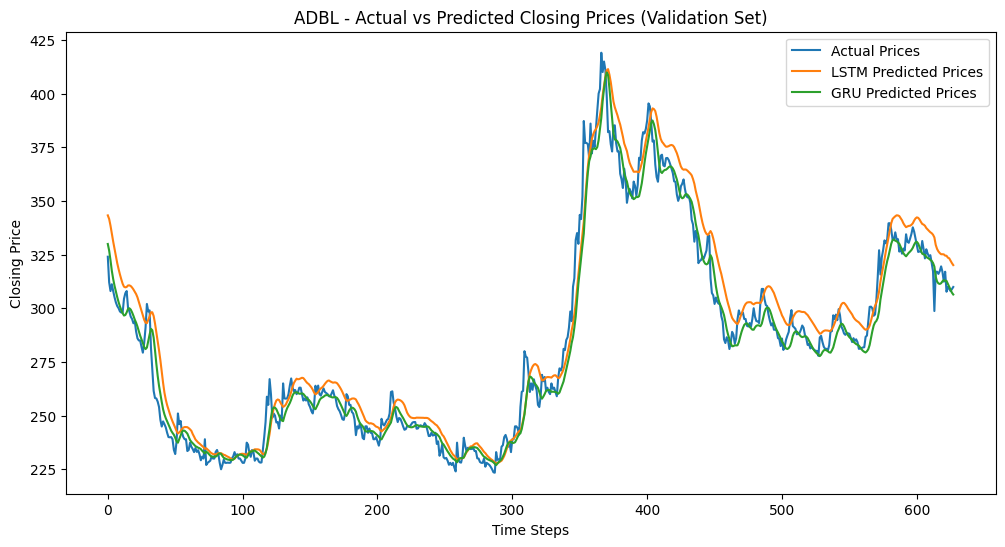

Loaded LSTM model and scaler for CZBIL
Loaded GRU model and scaler for CZBIL


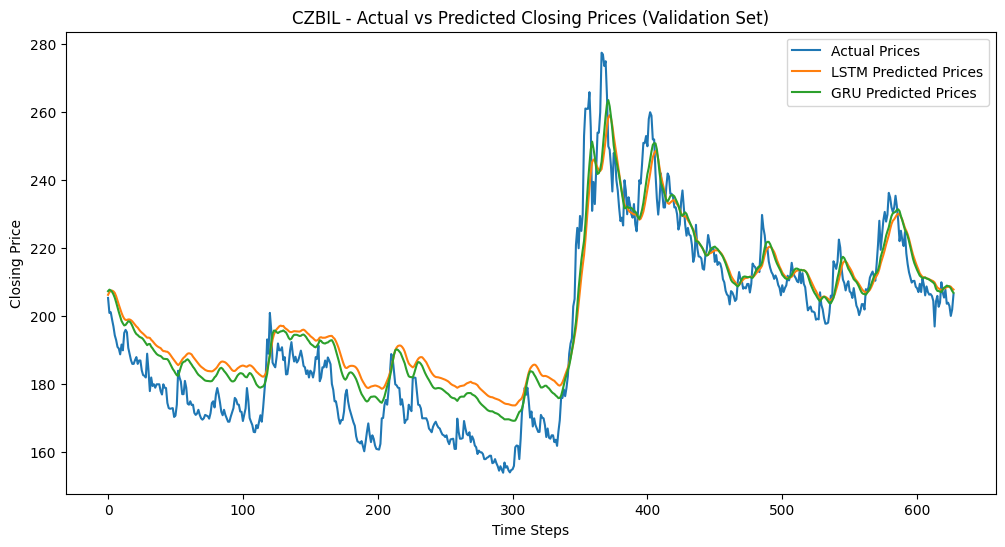

Loaded LSTM model and scaler for EBL
Loaded GRU model and scaler for EBL


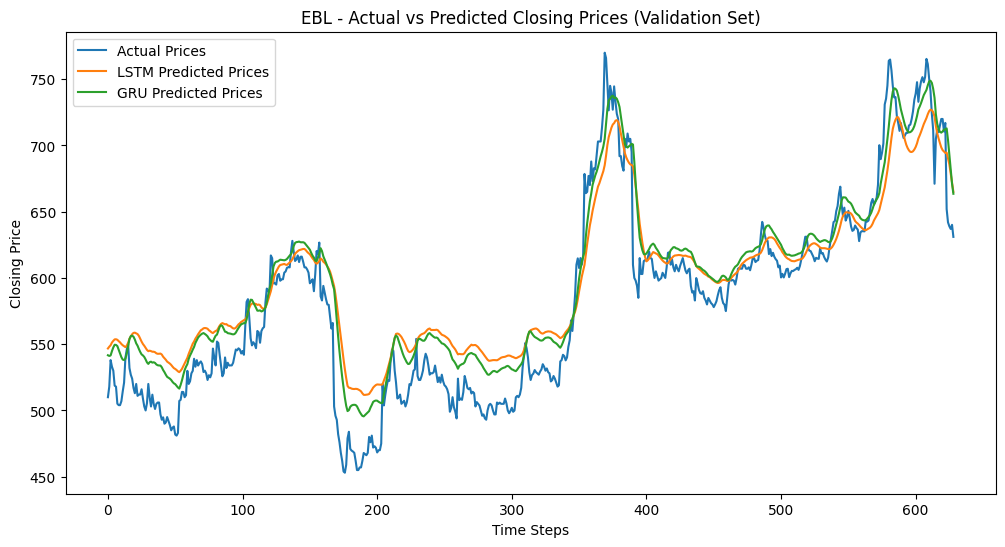

Loaded LSTM model and scaler for GBIME
Loaded GRU model and scaler for GBIME


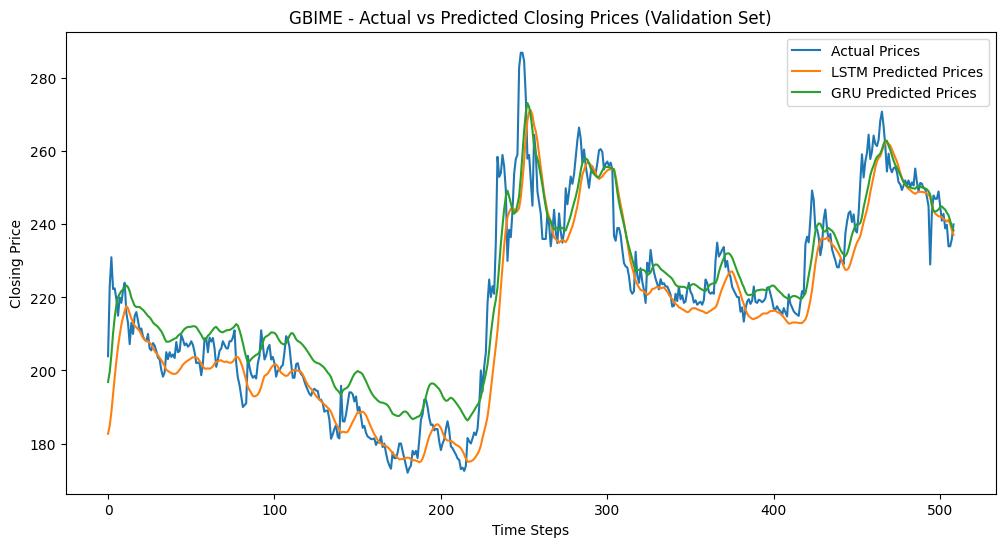

Loaded LSTM model and scaler for HBL
Loaded GRU model and scaler for HBL


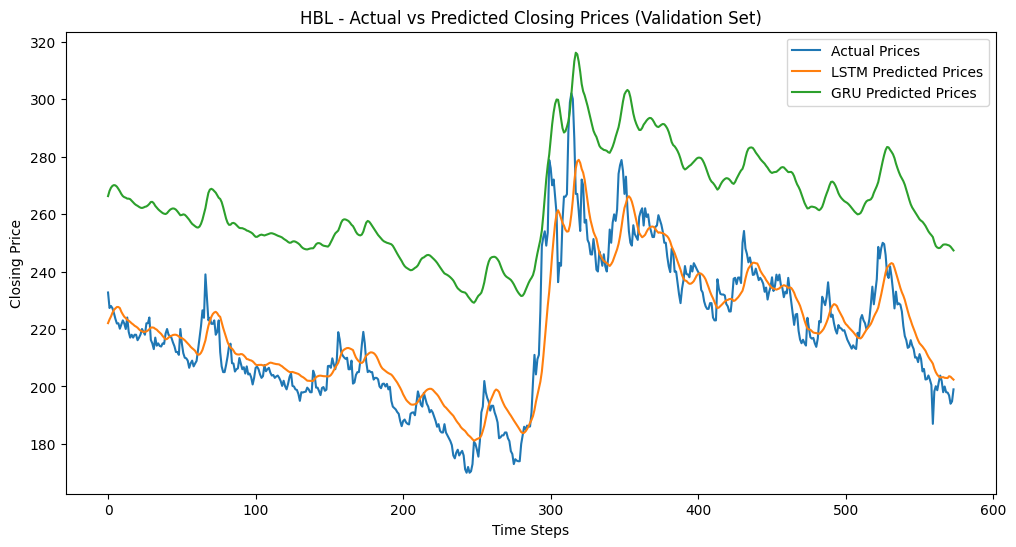

Loaded LSTM model and scaler for KBL
Loaded GRU model and scaler for KBL


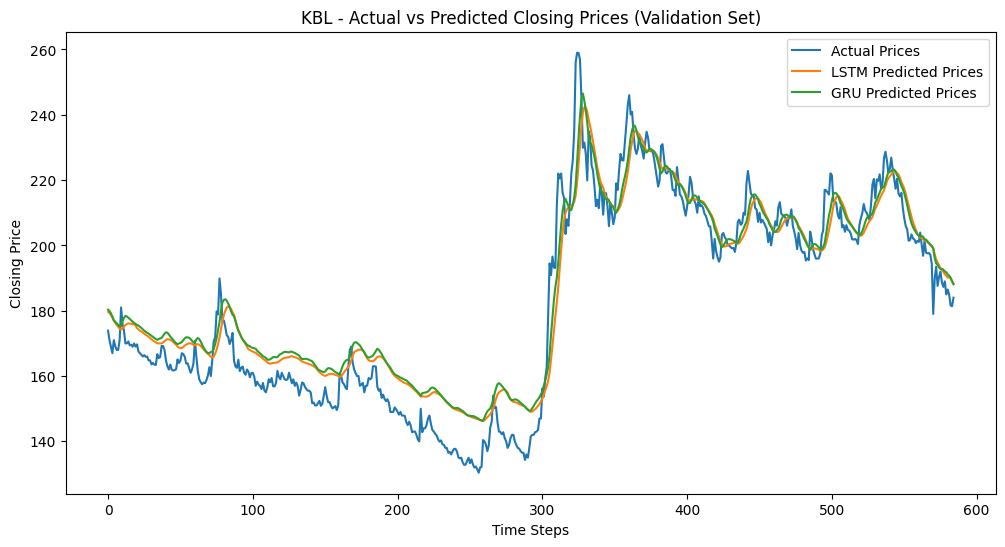

Loaded LSTM model and scaler for MBL
Loaded GRU model and scaler for MBL


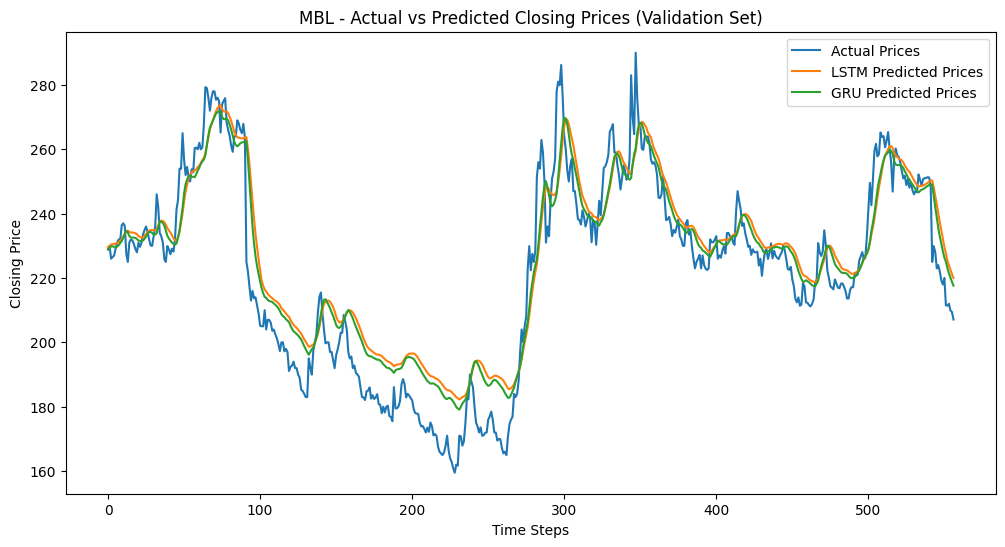

Loaded LSTM model and scaler for NABIL
Loaded GRU model and scaler for NABIL


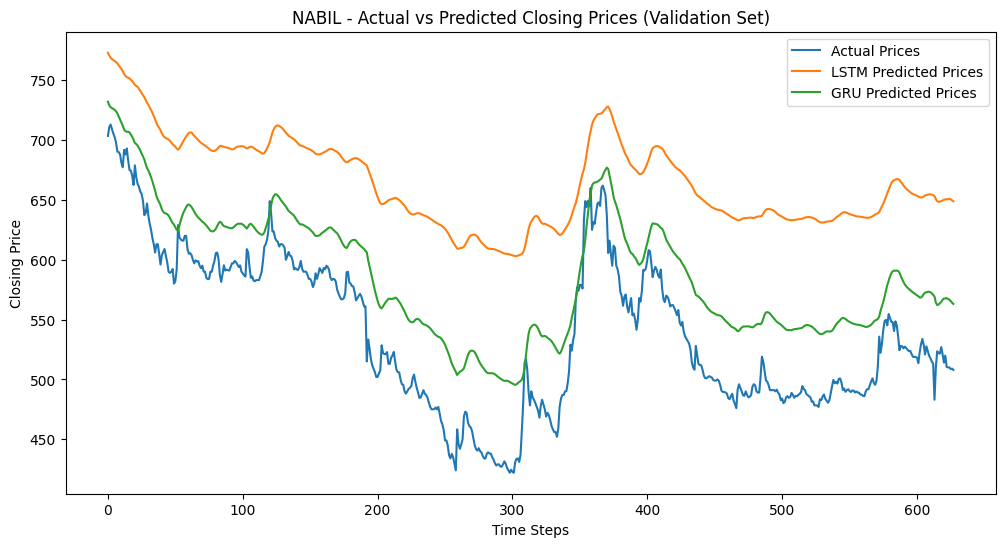

Loaded LSTM model and scaler for NBL
Loaded GRU model and scaler for NBL


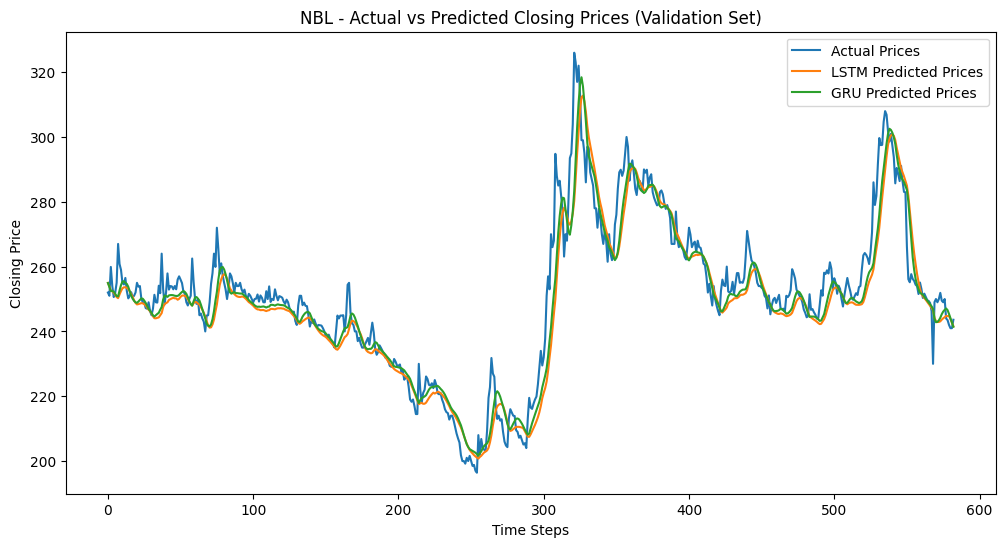

Loaded LSTM model and scaler for NICA
Loaded GRU model and scaler for NICA


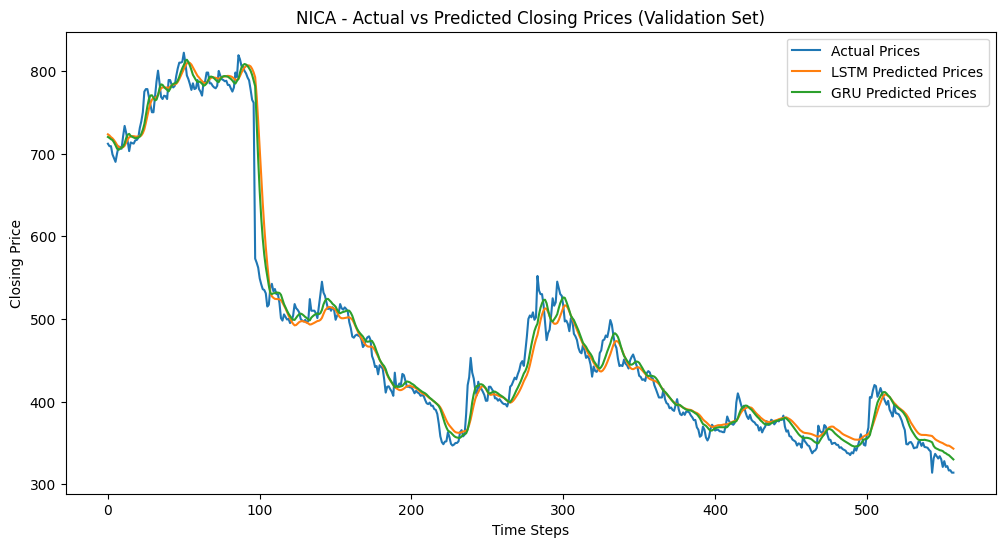

Loaded LSTM model and scaler for NIMB
Loaded GRU model and scaler for NIMB


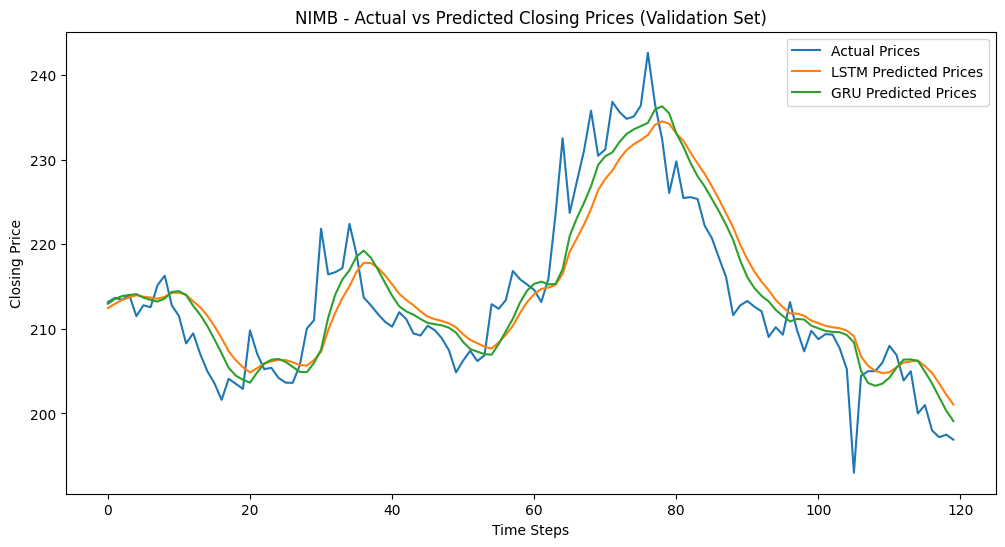

Loaded LSTM model and scaler for NMB
Loaded GRU model and scaler for NMB


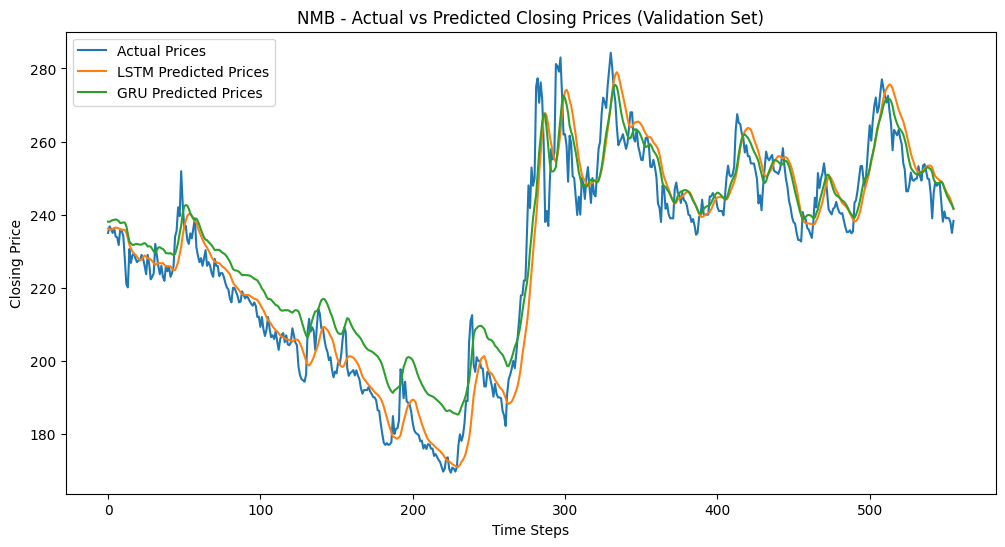

Loaded LSTM model and scaler for PRVU
Loaded GRU model and scaler for PRVU


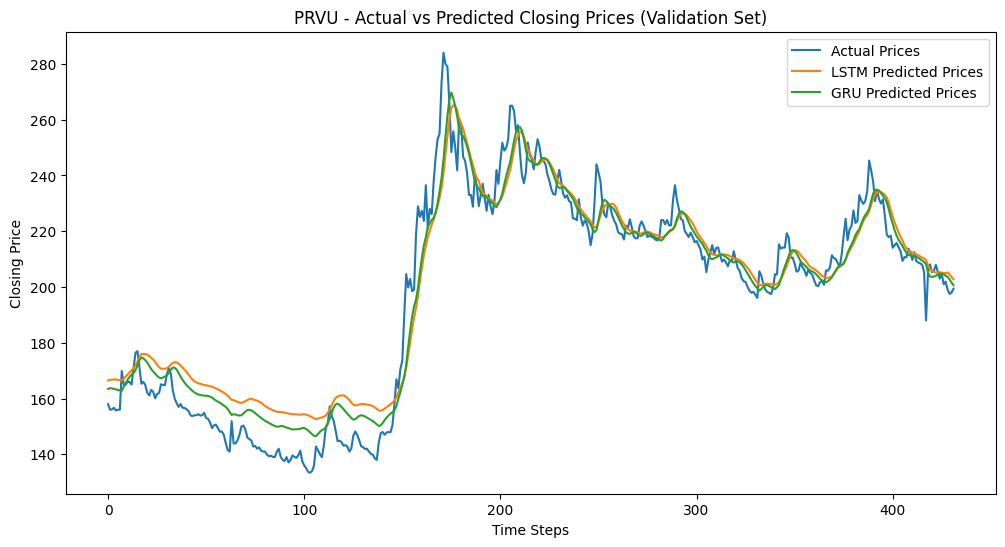

Loaded LSTM model and scaler for SANIMA
Loaded GRU model and scaler for SANIMA


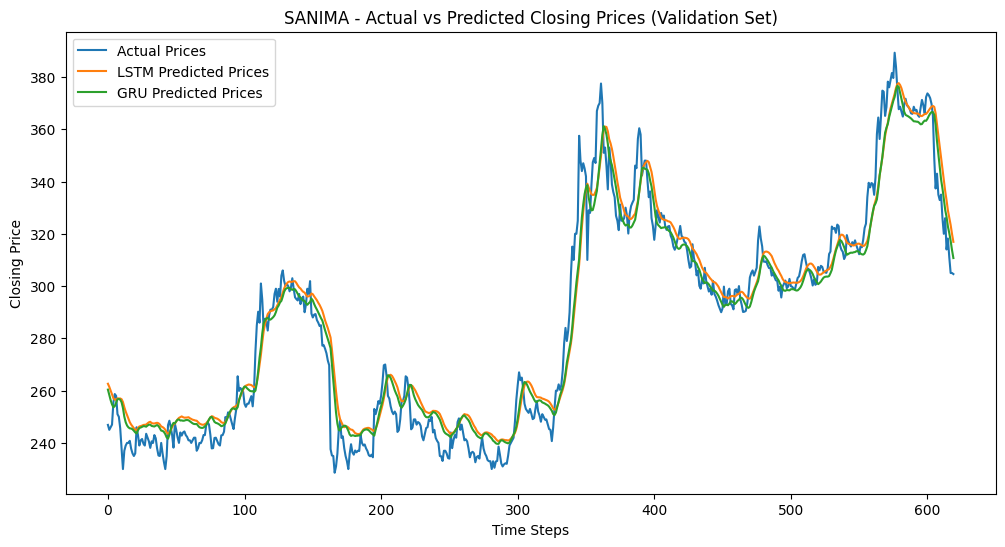

Loaded LSTM model and scaler for SBI
Loaded GRU model and scaler for SBI


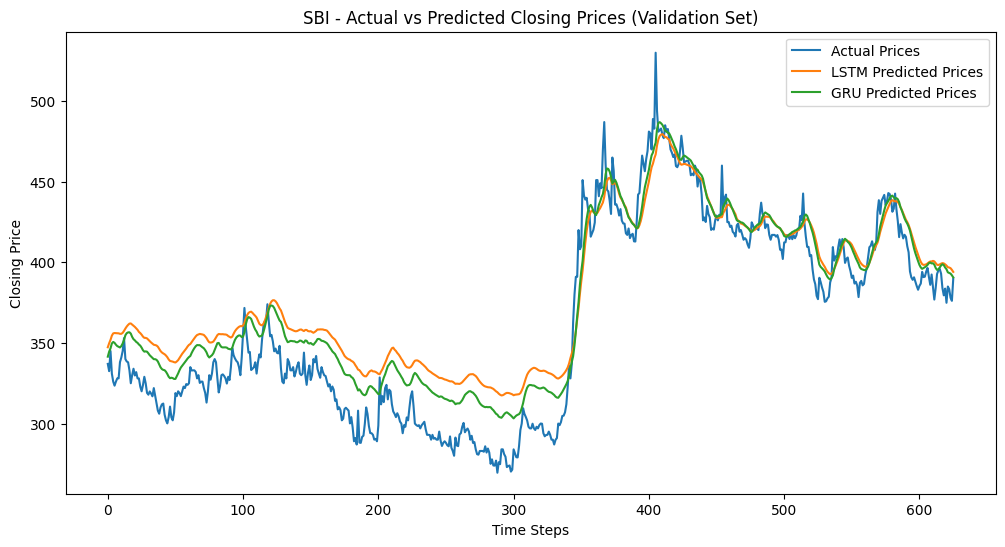


--- Plotting complete ---


In [28]:
import matplotlib.pyplot as plt

print("\n--- Plotting Validation Predictions vs Actuals ---")

for Symbol in lstm_models.keys():  # Iterate through the symbols that have trained models
    # Get the validation data for the current Symbol
    stock_df = df_filtered[df_filtered['Symbol'] == Symbol].copy()
    stock_df['Date'] = pd.to_datetime(stock_df['Date'])
    stock_df = stock_df.sort_values('Date').reset_index(drop=True)
    close_prices = stock_df['Close'].values.reshape(-1, 1)

    # Load both LSTM and GRU scalers for the current Symbol
    lstm_scaler = lstm_scalers.get(Symbol)
    gru_scaler = gru_scalers.get(Symbol)

    if lstm_scaler is None or gru_scaler is None:
        print(f"Scaler not found for {Symbol}. Skipping plotting.")
        continue

    # Scale the prices using one of the scalers (StandardScaler fit on the whole data)
    scaled_prices = lstm_scaler.transform(close_prices)  # Scaler is the same for both models

    # Create sequences for validation
    X, y = create_sequences(scaled_prices, SEQUENCE_LENGTH)

    train_size = int(len(X) * TRAIN_SPLIT_PERCENT)
    X_val, y_val = X[train_size:], y[train_size:]

    # Convert to PyTorch Tensors and move to the selected device
    X_val = torch.from_numpy(X_val).float().to(device)
    y_val = torch.from_numpy(y_val).float().to(device)

    # Load both LSTM and GRU models for the current Symbol
    lstm_model, _ = load_stock_model(Symbol, model_dir, model_type='LSTM')
    gru_model, _ = load_stock_model(Symbol, model_dir, model_type='GRU')

    if lstm_model is None or gru_model is None:
        print(f"Models not found for {Symbol}. Skipping plotting.")
        continue

    # Make predictions on the validation set using both models
    lstm_model.eval()
    gru_model.eval()
    with torch.no_grad():
        y_pred_val_scaled_lstm = lstm_model(X_val)
        y_pred_val_scaled_gru = gru_model(X_val)

    # Inverse transform the predictions and actual values
    y_val_actual = lstm_scaler.inverse_transform(y_val.cpu().numpy())  # Use either scaler
    y_pred_val_lstm = lstm_scaler.inverse_transform(y_pred_val_scaled_lstm.cpu().numpy())
    y_pred_val_gru = gru_scaler.inverse_transform(y_pred_val_scaled_gru.cpu().numpy())

    # Plot the actual vs predicted values for both models
    plt.figure(figsize=(12, 6))
    plt.plot(y_val_actual, label='Actual Prices')
    plt.plot(y_pred_val_lstm, label='LSTM Predicted Prices')
    plt.plot(y_pred_val_gru, label='GRU Predicted Prices')
    plt.title(f'{Symbol} - Actual vs Predicted Closing Prices (Validation Set)')
    plt.xlabel('Time Steps')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()

print("\n--- Plotting complete ---")


In [29]:
from google.colab import files
import shutil

# First, zip the trained_models folder
shutil.make_archive("trained_models", 'zip', "trained_models")

# Then download the zip file
files.download("trained_models.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

| बैंक नाम                            | शेयर चिन्ह                |
| ----------------------------------- | ------------------------- |
| Agriculture Development Bank Ltd.   | ADBL ([Merolagani][1])    |
| Bank of Kathmandu Ltd.              | BOKL ([Investopaper][2])  |
| Century Commercial Bank Ltd.        | CCBL ([Investopaper][2])  |
| Citizens Bank International Ltd.    | CZBIL ([Investopaper][2]) |
| Civil Bank Ltd.                     | CBL ([Investopaper][2])   |
| Everest Bank Ltd.                   | EBL ([Merolagani][1])     |
| Global IME Bank Ltd.                | GBIME ([Investopaper][2]) |
| Himalayan Bank Ltd.                 | HBL ([Investopaper][2])   |
| Kumari Bank Ltd.                    | KBL ([Investopaper][2])   |
| Laxmi Bank Ltd.                     | LBL ([Investopaper][2])   |
| Machhapuchhre Bank Ltd.             | MBL ([Merolagani][1])     |
| Mega Bank Nepal Ltd.                | MEGA ([Investopaper][2])  |
| Nabil Bank Ltd.                     | NABIL ([Investopaper][2]) |
| Nepal Bangladesh Bank Ltd.          | NBB ([AT Nepal][3])       |
| Nepal Bank Ltd.                     | NBL ([Merolagani][1])     |
| Nepal Credit And Commerce Bank Ltd. | NCCB ([Investopaper][2])  |
| Nepal Investment Bank Ltd.          | NIB ([Investopaper][2])   |
| Nepal SBI Bank Ltd.                 | SBI ([Investopaper][2])   |
| NIC Asia Bank Ltd.                  | NICA ([Merolagani][1])    |
| NMB Bank Ltd.                       | NMB ([Merolagani][1])     |
| Prabhu Bank Ltd.                    | PRVU ([Merolagani][1])    |
| Prime Commercial Bank Ltd.          | PCBL ([Merolagani][1])    |
| Sanima Bank Ltd.                    | SANIMA ([Merolagani][1])  |
| Siddhartha Bank Ltd.                | SBL ([Merolagani][1])     |
| Standard Chartered Bank Nepal Ltd.  | SCB ([Investopaper][2])   |

[1]: https://merolagani.com/CompanyList.aspx?utm_source=chatgpt.com "merolagani - Nepal Stock Exchange (NEPSE) Listed Companies"
[2]: https://www.investopaper.com/news/listed-companies-in-nepal-stock-exchange-nepse/?utm_source=chatgpt.com "Listed Companies In Nepal Stock Exchange (Nepse) | Investopaper"
[3]: https://atnepal.net/stock/?utm_source=chatgpt.com "Stock - Nepal Share Market"
